In [12]:
from tqdm import tqdm
import pickle
import torch
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
import torch.nn as nn
import torch.nn.functional as F
import os
import pandas as pd
import subprocess
import numpy as np
import torch
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
import os
from torch_geometric.loader import DataLoader
from pathlib import Path
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import DataLoader, Data
from torch_geometric.nn import GCNConv
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GATConv
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from collections import Counter
from torch_geometric.data import Data, Dataset
import json
import os
import pandas as pd
import pandas as pd
from rdkit import Chem
import torch
import numpy as np
from torch.utils.data import Dataset
import pickle
from collections import defaultdict
from pathlib import Path
import torch.nn.functional as F
import pickle
from tqdm import tqdm
import pickle
import torch
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
import torch.nn as nn
import torch.nn.functional as F
import os
import pandas as pd
import subprocess
import numpy as np
import torch
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
import os
from torch_geometric.loader import DataLoader
from pathlib import Path
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import DataLoader, Data
from torch_geometric.nn import GCNConv
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GATConv
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from collections import Counter
from torch_geometric.data import Data, Dataset
import json
import os
import pandas as pd
import pandas as pd
from rdkit import Chem
import torch
import numpy as np
from torch.utils.data import Dataset
import pickle
from collections import defaultdict
from pathlib import Path
import torch.nn.functional as F
import pickle
import json 

In [38]:
%run ../Config.ipynb
config = Config()
pdbs = os.listdir(config.set)
nposes = config.docking_params['nposes']
batch_size  = config.model_args['batch_size']
path_scripts = Path(os.getcwd())
num_epochs = config.model_args['epochs']
num_folds = config.model_args['nfolds']
patience = config.model_args['patience']  # Set your desired patience value
binana_executable = config.executables['binana']

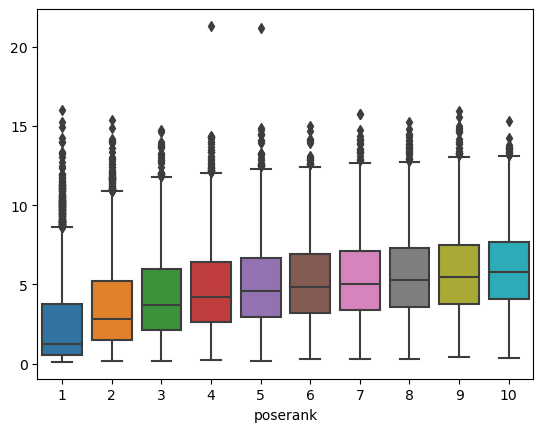

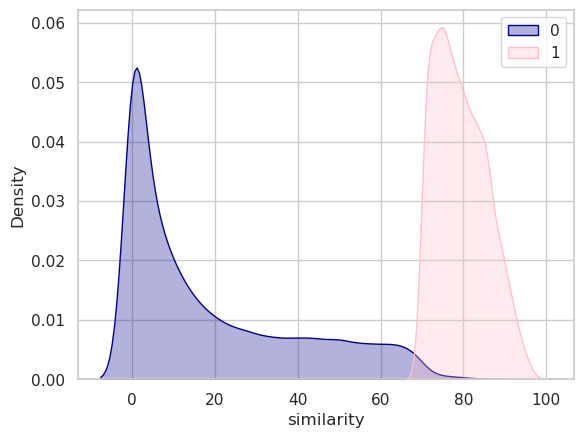

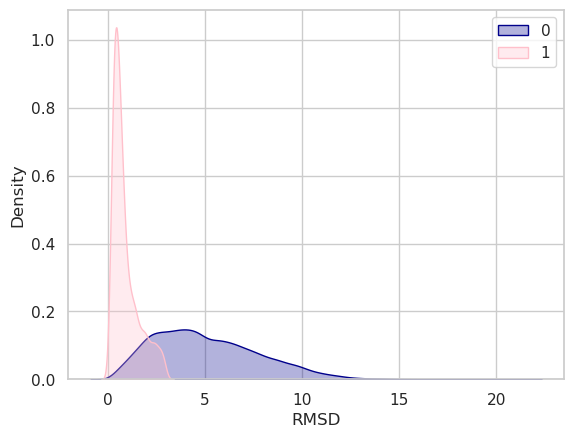

label.json saved at: ../Datahub/Data


/tmp/ipykernel_73427/4027079687.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lepton = lepton.append({"pdb":pdb, "class":class_}, ignore_index = True)
/tmp/ipykernel_73427/4027079687.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lepton = lepton.append({"pdb":pdb, "class":class_}, ignore_index = True)
/tmp/ipykernel_73427/4027079687.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lepton = lepton.append({"pdb":pdb, "class":class_}, ignore_index = True)
/tmp/ipykernel_73427/4027079687.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lepton = lepton.append({"pdb":pdb, "class":class_}, ignore_index = True)
/tmp/ipykernel_7

5316

In [39]:
%run Label.ipynb
label = pd.read_json(f"{config.data}/label.json").fillna(0)
len(label.columns)

In [40]:
with open(f'{config.root}/{config.project_name}/{config.dicts}/combined_dicts_atoms_prop.pkl','rb') as f:
        combined_dict_atoms_prop = pickle.load(f)

In [61]:
%%time
class Get_dataset():
    def __init__(self, pdbs, lig_atoms_prop, rec_atoms_prop, df_dict, subsample=None, preprocessed_protgraph=True):
        self.pdbs = pdbs
        self.lig_atoms_prop = combined_dict_atoms_prop['lig_atoms_prop']
        self.rec_atoms_prop = combined_dict_atoms_prop['rec_atoms_prop']
        self.df_dict = combined_dict_atoms_prop['df_dict']
        self.protgraph_dict = self.get_unique_prot_graphs()
        self.preprocessed_protgraph=preprocessed_protgraph
        self.subsample = subsample 

        
    def map_node_names_to_indices(self, edge_index):
        unique_node_names_0, node_name_to_index_0 = torch.unique(edge_index[0], sorted=True, return_inverse=True)
        unique_node_names_1, node_name_to_index_1 = torch.unique(edge_index[1], sorted=True, return_inverse=True)
    
        # Map the node names to their corresponding indices separately for edge_index[0] and edge_index[1]
        updated_edge_index_0 = node_name_to_index_0.view(1, -1)
        updated_edge_index_1 = node_name_to_index_1.view(1, -1)
    
        # Combine the updated edge indices back into the same format as edge_index
        updated_edge_index = torch.cat((updated_edge_index_0, updated_edge_index_1), dim=0)
    
        return updated_edge_index
        
    def get_unique_prot_graphs(self):
        protgraph_dict = {}
        failed_protgraph = []

        for pdb in self.pdbs:
            protgraph_dict[pdb] = {}
            for pose in range(1, nposes + 1):
                try:
                    x_s = torch.tensor(np.array(self.lig_atoms_prop[pdb][pose].iloc[:, 1:].astype("float32")))
                    x_t = torch.tensor(np.array(self.rec_atoms_prop[pdb][pose].iloc[:, 1:].astype("float32")))
                    edge_index = torch.tensor(np.array([self.df_dict[pdb][pose]["ligand_atom_index"].astype("int64"),
                                                    self.df_dict[pdb][pose]["receptor_atom_index"].astype("int64")]))
                
                    edge_index = self.map_node_names_to_indices(edge_index)
                    distances = torch.tensor(np.array(self.df_dict[pdb][pose]['distance']).astype("float32"))
                    #print('x_s: ', x_s)
                    protgraph_dict[pdb][pose] = {'x_s': x_s, # Ligand
                                             'x_t': x_t, # Receptor
                                             'edge_index': edge_index,
                                             'edge_attr': distances,
                                             }
                except Exception as e:
                    #print('Error')
                    continue
        return protgraph_dict


    def process(self):
        print('processessing....')
        if self.preprocessed_protgraph:
            with open(f'{config.root}/{config.project_name}/{config.dicts}/protgraph_dict.pkl','rb') as f:
               protgraph_dict = pickle.load(f)
        else:
            protgraph_dict = self.get_unique_prot_graphs()
            with open(f'{config.root}/{config.project_name}/{config.dicts}/protgraph_dict.pkl','wb') as f:
                pickle.dump(protgraph_dict,f)
         
        for pdb in tqdm(pdbs, desc = 'PDBs'):
            for pose in range(1, nposes + 1): 

                try: 
                             #  self.protgraph_dict[pdb][pose]
                    protgraph = protgraph_dict[pdb][pose] ### Needs alteration to open saved dict, lets got with it righ now
    
                    interaction_id = str(pdb) + "_" + str(pose)                 
         
                    x_s, x_t, edge_index, edge_attr= protgraph['x_s'], protgraph['x_t'], protgraph['edge_index'],protgraph['edge_attr']
    
                    #y = torch.randint(2, (1,), dtype=torch.float32)
                    try:
                        y = torch.tensor(label[pdb][pose], dtype=torch.float32)
                    except Exception as e:
                        print(f"Error: {e}")
                        continue
                    #y = label[pdb][pose].astype("float32")
                    data = BipartiteData(edge_index=edge_index, x_s=x_s, x_t=x_t, y=y, edge_attr = edge_attr, pdb = pdb, pose = pose)
                    #print(f'saving data {config.processed_dir}')
                    torch.save(data, os.path.join(config.processed_dir, f'data_{interaction_id}.pt'))  

                except Exception as e:
                    #print(f"Error: {e}")
                    continue

    
    def processed_file_names(self):
        datalist =   [torch.load(os.path.join(config.processed_dir, f'{filename}')) for filename in os.listdir(config.processed_dir)]
        return datalist

   # def __len__(self):
   #     return len(protgraph_dict)  ###
   # 
   #def __getitem__(self, index):
   #    pdb = self.pdbs[index]
   #    pose = 1  # You may need to modify this
   #    data_sample = self.protgraph_dict[pdb][pose]
   #    return data_sample

  

dataset = Get_dataset(pdbs, combined_dict_atoms_prop['lig_atoms_prop'], combined_dict_atoms_prop['rec_atoms_prop'], combined_dict_atoms_prop['df_dict'])

CPU times: user 43.7 s, sys: 137 ms, total: 43.8 s
Wall time: 44.2 s


In [62]:
class BipartiteData(Data):
    def __init__(self, edge_index=None, x_s=None, x_t=None, y=None, edge_attr=None, pdb = None, pose = None):
        super().__init__()
        self.edge_index = edge_index
        self.x_s = x_s
        self.x_t = x_t
        self.y = y
        self.edge_attr = edge_attr  # Add edge_attr attribute
        #self.num_nodes = len(set(edge_index[0].tolist())) +  len(set(edge_index[1].tolist()))
        self.num_nodes = (x_s.size(0) if x_s is not None else 0) + (x_t.size(0) if x_t is not None else 0)
        self.pdb = pdb
        self.pose = pose
    
    def __inc__(self, key, value, *args, **kwargs):
        if key == 'edge_index':
            return torch.tensor([[self.x_s.size(0)], [self.x_t.size(0)]])
        else:
            return super().__inc__(key, value, *args, **kwargs)

In [63]:
%%time
dataset.process()
dataset_list = dataset.processed_file_names()

processessing....


100%|██████████████████████████████████████| 5316/5316 [00:24<00:00, 213.40it/s]


CPU times: user 56.3 s, sys: 6.41 s, total: 1min 2s
Wall time: 1min 3s


In [64]:
len(dataset_list)

39140

In [65]:
config.node_descriptors

['Mass',
 'Charge',
 'Element_Name',
 'Hybridization',
 'Num_Hydrogens',
 'Formal_Charge',
 'Unpaired_Electron',
 'In_Aromatic_Substructure']

In [66]:
for test in dataset_list:
    if test.pdb == '4eor':
        print(test)

In [67]:
dataset_list[6].x_t[0:10]

tensor([[0., 0., 3., 2., 0., 0., 0.],
        [0., 0., 3., 2., 0., 0., 0.],
        [0., 0., 3., 1., 0., 0., 0.],
        [0., 3., 2., 0., 0., 0., 0.],
        [0., 0., 3., 2., 0., 0., 0.],
        [0., 0., 3., 2., 0., 0., 0.],
        [0., 3., 2., 0., 0., 0., 0.],
        [0., 0., 3., 2., 0., 0., 0.],
        [0., 3., 2., 0., 0., 0., 0.],
        [0., 0., 3., 2., 0., 0., 0.]])

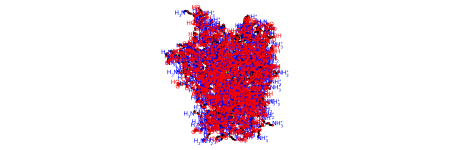

In [68]:
pdb = '4j28'
pose = 7
ligand_path =   f"{config.set}/{pdb}/results/pose_{pose}.pdb"
protein_path =  f"{config.set}/{pdb}/{pdb}_protein_fixed.pdb"
molecule = Chem.MolFromPDBFile(protein_path, removeHs=False)
molecule

### Saving pkl

In [69]:
cut = 4
name = f"bipartite_data_no_pose_rank_sorted_by_family_cut_{cut}_refined_set.pkl" 
name_encoded = f"bipartite_data_no_pose_rank_sorted_by_family_cut_{cut}_refined_set_encoded.pkl" 
# bipartite_data_with_pose_pred.pkl

In [70]:
# Save the list to a file
with open(f'{config.data}/{name}', 'wb') as file:
    pickle.dump(dataset_list, file)
    print('Saved with sucess!')

Saved with sucess!


In [71]:
dataset_list[4].x_s[0:10]

tensor([[0., 0., 2., 0., 0., 0., 1.],
        [0., 0., 2., 0., 0., 0., 1.],
        [0., 0., 2., 0., 0., 0., 1.],
        [0., 0., 2., 1., 0., 0., 1.],
        [0., 0., 2., 1., 0., 0., 1.],
        [0., 0., 2., 1., 0., 0., 1.],
        [0., 0., 2., 1., 0., 0., 1.],
        [0., 0., 2., 1., 0., 0., 1.],
        [0., 0., 2., 1., 0., 0., 1.],
        [0., 0., 2., 1., 0., 0., 1.]])

##### Opening pkl 

In [72]:
with open(f'{config.data}/{name}', 'rb') as file:
    dataset_list_opened = pickle.load(file)
len(dataset_list_opened)

39140

##### Filter data list 

In [73]:


filtered_data_list_num_nodes = [data for data in dataset_list_opened if data.num_nodes>0]
filtered_data_list_descriptors = [data for data in filtered_data_list_num_nodes if data.x_s.shape[0] > 0 and data.x_t.shape[0] > 0]
filtered_data_list_descriptors = [data for data in filtered_data_list_descriptors if not data.x_t[0,2].isnan()] 

filtered_data_list = filtered_data_list_descriptors.copy()

label_distribuition = dict(Counter([label.y.tolist() for label in filtered_data_list]))
amount_of_graphs_used_to_train = len(filtered_data_list)
filtered_data_list_descriptors = [data for data in filtered_data_list_descriptors if not data.x_t[0,2].isnan()] 

In [74]:
len(filtered_data_list)

27651

#### Ordering the data 

In [75]:
proper_order = list(pd.read_csv('/home/lbcb02/Workspace/BindRanker/BindRanker/Datahub/Data/depara_pdb_protein_name.csv').sort_values('Protein name')['PDB code'])

In [76]:
len(set(pdbs) - set(proper_order))

526

In [77]:
order_data = False
def pdb_index(item):
    try:
        return proper_order.index(item.pdb)
    except ValueError:
        return float('inf')  # Return a very large value if PDb not found
if order_data:
    filtered_data_list = sorted(filtered_data_list, key=pdb_index)
    

#### One-hot-enconding-Element_Name

In [78]:
import torch

def apply_one_hot_encoding_to_tensor(tensor, column_index, num_classes):
    column_data = tensor[:, column_index]
     
    one_hot_encoded = torch.nn.functional.one_hot(column_data.to(torch.int64), num_classes=num_classes)
    tensor = torch.cat((tensor, one_hot_encoded.float()), dim=1)
    tensor = torch.cat((tensor[:, :column_index], tensor[:, column_index + 1:]), dim=1)
 
        
    return tensor

def apply_one_hot_encoding_to_data(data_list, column_index, num_classes):
    i = 0 
    for index, data in enumerate(data_list):
        try:
            data.x_s = apply_one_hot_encoding_to_tensor(data.x_s, column_index, num_classes)
            data.x_t = apply_one_hot_encoding_to_tensor(data.x_t, column_index, num_classes)
        except Exception as e:
            print('Error: ', e, 'index', index)
            i += 1
    print('Total erros: ', i )

In [79]:
apply_one_hot_encoding_to_data(filtered_data_list, column_index=1, num_classes=5)

Total erros:  0


In [80]:
print("Nº Dataset to train ", len(filtered_data_list))

Nº Dataset to train  27651


### Saving pkl endoded

In [81]:
# Save the list to a file
with open(f'{config.data}/{name_encoded}', 'wb') as file:
    pickle.dump(filtered_data_list, file)
    print(f'Saved {name_encoded} with sucess!')

Saved bipartite_data_no_pose_rank_sorted_by_family_cut_4_refined_set_encoded.pkl with sucess!


In [82]:
with open(f'{config.data}/bipartite_data_no_pose_rank_sorted_by_family_cut_4_refined_set_encoded.pkl', 'rb') as file:
    dataset_list_final = pickle.load(file) 

In [83]:
for data in dataset_list_final:
    print(data)
    #print(data.x_s[0])
    #break

BipartiteData(edge_index=[2, 111], x_s=[111, 11], x_t=[111, 11], y=0.0, edge_attr=[111], num_nodes=222, pdb='5u14', pose=8)
BipartiteData(edge_index=[2, 48], x_s=[48, 11], x_t=[48, 11], y=0.0, edge_attr=[48], num_nodes=96, pdb='5sz3', pose=7)
BipartiteData(edge_index=[2, 118], x_s=[118, 11], x_t=[118, 11], y=0.0, edge_attr=[118], num_nodes=236, pdb='6szp', pose=7)
BipartiteData(edge_index=[2, 50], x_s=[50, 11], x_t=[50, 11], y=0.0, edge_attr=[50], num_nodes=100, pdb='3pb9', pose=1)
BipartiteData(edge_index=[2, 62], x_s=[62, 11], x_t=[62, 11], y=0.0, edge_attr=[62], num_nodes=124, pdb='4ibc', pose=7)
BipartiteData(edge_index=[2, 165], x_s=[165, 11], x_t=[165, 11], y=0.0, edge_attr=[165], num_nodes=330, pdb='5izj', pose=7)
BipartiteData(edge_index=[2, 38], x_s=[38, 11], x_t=[38, 11], y=0.0, edge_attr=[38], num_nodes=76, pdb='4llp', pose=3)
BipartiteData(edge_index=[2, 56], x_s=[56, 11], x_t=[56, 11], y=0.0, edge_attr=[56], num_nodes=112, pdb='1g45', pose=9)
BipartiteData(edge_index=[2, 3

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

